In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns
from itertools import chain

In [2]:
# Set random seed for numpy
np.random.seed(11)
# Set random seed for pytorch
torch.manual_seed(11)
# Set random seed for pytorch running in GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(11)

In [3]:
# Choose batch size
batch_size = 32

In [4]:
# Load processed data
UCI_train_features = np.load('./multi/UCI_train_features_32_multi.npy', allow_pickle=True)
UCI_train_labels = np.load('./multi/UCI_train_labels_32_multi.npy', allow_pickle=True)
UCI_test_features = np.load('./multi/UCI_test_features_32_multi.npy', allow_pickle=True)
UCI_test_labels = np.load('./multi/UCI_test_labels_32_multi.npy', allow_pickle=True)
# Subtract 1 for every label for correct training, i.e., [1,2,3,4,5,6] to [0,1,2,3,4,5]
UCI_train_labels = UCI_train_labels.astype(int) - 1
UCI_test_labels = UCI_test_labels.astype(int) - 1

In [5]:
# Drop the last one row of the activity images
UCI_train_features = UCI_train_features[:,:-1,:]
UCI_test_features = UCI_test_features[:,:-1,:]

In [6]:
# Transform to torch tensor
tensor_UCI_train_features = torch.Tensor(UCI_train_features) 
tensor_UCI_train_labels = torch.Tensor(UCI_train_labels)
tensor_UCI_test_features = torch.Tensor(UCI_test_features) 
tensor_UCI_test_labels = torch.Tensor(UCI_test_labels)
# Add one dimension of channel
tensor_UCI_train_features = torch.unsqueeze(tensor_UCI_train_features, 1)
tensor_UCI_test_features = torch.unsqueeze(tensor_UCI_test_features, 1)
# Create datset
train_dataset_UCI = TensorDataset(tensor_UCI_train_features,tensor_UCI_train_labels)
test_dataset_UCI = TensorDataset(tensor_UCI_test_features,tensor_UCI_test_labels)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_UCI, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_UCI, batch_size=batch_size, shuffle=False)

In [8]:
classes = ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING')

In [9]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

29408
11788


In [10]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels)
    break

torch.Size([32, 1, 36, 96])
tensor([1., 5., 4., 5., 1., 5., 1., 3., 1., 3., 2., 0., 0., 0., 4., 1., 5., 3.,
        1., 5., 1., 1., 4., 5., 2., 2., 3., 3., 0., 3., 5., 1.])


The CNN architecture is: 16C5$\times$5-S2$\times$2-32C5$\times$5

In [11]:
# Layers parameters:
original_image_length = 36
original_image_width = 96
max_pool1_kernel_size = 2
final_image_length = int(original_image_length / max_pool1_kernel_size)
final_image_width = int(original_image_width / max_pool1_kernel_size)
channels_L1 = 16
channels_L2 = 32
nodes_FC1 = 1000
nodes_FC2 = 6

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, channels_L1, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = max_pool1_kernel_size, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(channels_L1, channels_L2, kernel_size=7, stride=1, padding=3),
            nn.ReLU())
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(final_image_length * final_image_width * channels_L2, nodes_FC1)
        self.fc2 = nn.Linear(nodes_FC1, nodes_FC2)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [12]:
# Choose CPU or GPU
# model = ConvNet() #CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device) #GPU

# Hyperparameter
num_epochs = 10
learning_rate = 0.000006
weight_decay = 0.0001
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #Adding Weight Decay here is equivalent to adding L2 regularization

In [13]:
# Train the model on GPU
total_step = len(train_loader)
loss_list = []
acc_list = []
model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device).long()).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [300/919], Loss: 0.5048, Accuracy: 84.38%
Epoch [1/10], Step [600/919], Loss: 0.4491, Accuracy: 87.50%
Epoch [1/10], Step [900/919], Loss: 0.3344, Accuracy: 87.50%
Epoch [2/10], Step [300/919], Loss: 0.5268, Accuracy: 87.50%
Epoch [2/10], Step [600/919], Loss: 0.2719, Accuracy: 87.50%
Epoch [2/10], Step [900/919], Loss: 0.6054, Accuracy: 87.50%
Epoch [3/10], Step [300/919], Loss: 0.3053, Accuracy: 84.38%
Epoch [3/10], Step [600/919], Loss: 0.1434, Accuracy: 96.88%
Epoch [3/10], Step [900/919], Loss: 0.2421, Accuracy: 90.62%
Epoch [4/10], Step [300/919], Loss: 0.3428, Accuracy: 87.50%
Epoch [4/10], Step [600/919], Loss: 0.1167, Accuracy: 93.75%
Epoch [4/10], Step [900/919], Loss: 0.1424, Accuracy: 90.62%
Epoch [5/10], Step [300/919], Loss: 0.1015, Accuracy: 96.88%
Epoch [5/10], Step [600/919], Loss: 0.1281, Accuracy: 93.75%
Epoch [5/10], Step [900/919], Loss: 0.3299, Accuracy: 87.50%
Epoch [6/10], Step [300/919], Loss: 0.2227, Accuracy: 87.50%
Epoch [6/10], Step [600/

Test Accuracy of the model on the UCIHAR test images: 88.82762130980659 %


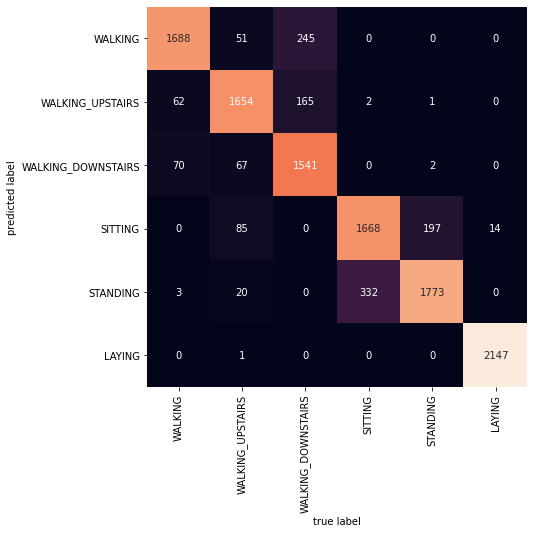

In [14]:
# Test the model on GPU
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the UCIHAR test images: {} %'.format((correct / total) * 100))

mat = metrics.confusion_matrix(torch.cat(all_predictions).cpu(), torch.cat(all_labels).cpu())
plt.figure(figsize=(7,7))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');